> Before running this notebook, follow these instructions from the README:

### Getting Started

1. Clone the repository (bash terminal)

```bash
git clone https://github.com/angelakberry/beauty_wizard.git
cd beauty_wizard
```
2. Set up environment and database (bash terminal)

```bash
chmod +x setup_beautywiz.sh
./setup_beautywiz.sh
```

3. Open the Jupyter Notebook
- Run all cells in `bbbbbbbbbBeautyWizard_Capstone.ipynb`

# Beauty Wizard: Cosmetic Ingredient Transparency & Risk Indicators

## 1. Introduction

This capstone project synthesizes multiple exploratory and pipeline notebooks into a single, end-to-end analysis aligned with data analysis capstone requirements. The objective is to examine cosmetic product formulations, ingredient usage patterns, and regulatory risk signals by integrating retail product data, ingredient hazard sources, and government chemical reporting into a relational SQLite database.

**Core Questions**

* Which ingredients are most prevalent across cosmetic products?
* How complex are typical cosmetic formulations?
* Do higher-priced or higher-ranked products differ in ingredient diversity or risk indicators?
* Which ingredients appear most frequently in regulatory or hazard datasets?

---



## 2. Imports & Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import re
import seaborn as sns
import sqlite3

plt.rcParams['figure.figsize'] = (10,6)

## 3. Data Sources

* Sephora Skincare Product Ingredients (Kaggle CSV) (cosmetic_p.csv)
* BeautyFeeds Skincare & Haircare Dataset (BeautyFeeds.csv)
* California Safe Cosmetics Program (CSCP) Open Data (cscpopendata.csv)

Product and ingredient data from these sources are consolidated into a master Ingredients table, which serves as the central join point for product composition and regulatory hazard data sourced from California Chemicals in Cosmetics.

In [2]:
# Import data
DATA = Path("data")

cosmetic = pd.read_csv(DATA / "cosmetic_p.csv")
beauty = pd.read_csv(DATA / "BeautyFeeds.csv")
cscp = pd.read_csv(DATA / "cscpopendata.csv")

## 4. Data Analysis
### 4a. Cleaning & Standardization
"Normalization" defined:
- Standardized text (case, whitespace, characters)
- Consistent column names (e.g., ChemicalName becomes chemical_name)
- Consistent missing-value handling
- Consistent data types
- Reusable, universal dataset logic

In [3]:
def normalize(name):
    if pd.isna(name):
        return None
    name = re.sub(r"\s+", " ", name.strip())
    return name.lower()

In [4]:
# Text normalization (for any and all string columns)
def normalize_text(value):
    if pd.isna(value):
        return None
    value = str(value).strip()
    value = re.sub(r"\s+", " ", value)
    return value.lower()

In [5]:
# Column name normalization
def normalize_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
    )
    return df

In [6]:
# Generic dataframe text normalization
def normalize_text_columns(df, columns):
    df = df.copy()
    for col in columns:
        if col in df.columns:
            df[col] = df[col].apply(normalize_text)
    return df

In [7]:
# Coerce price to numeric, invalid values become NaN
cosmetic['price'] = pd.to_numeric(cosmetic['price'], errors='coerce')

# Inspect missing values introduced by coercion
cosmetic['price'].isna().sum()

np.int64(0)

### 4b. Apply normalization to each dataset:

In [8]:
# Cosmetic product dataset
cosmetic = normalize_columns(cosmetic)

# Rename product category labels for clearer semantics
cosmetic.rename(columns={'label': 'product_type'}, inplace=True)
cosmetic.rename(columns={'name': 'product_name'}, inplace=True)

# Text normalization
cosmetic = normalize_text_columns(
    cosmetic,
    ['brand', 'product_name', 'product_type', 'ingredients']
)

# Remove rows missing key evaluation metrics
cosmetic_cleaned = cosmetic.dropna(subset=['rank'])

In [9]:
cosmetic.columns

Index(['product_type', 'brand', 'product_name', 'price', 'rank', 'ingredients',
       'combination', 'dry', 'normal', 'oily', 'sensitive'],
      dtype='object')

In [10]:
# BeautyFeeds dataset
beauty = normalize_columns(beauty)

# Rename product category labels for clearer semantics
beauty.rename(columns={'type': 'product_type'}, inplace=True)
beauty.rename(columns={'name': 'product_name'}, inplace=True)

# Text normalization
beauty = normalize_text_columns(
    beauty,
    ['ingredients', 'brand', 'name']
)

In [11]:
beauty.columns

Index(['uniq_id', 'product_type', 'brand', 'product_name', 'price',
       'ingredients'],
      dtype='object')

In [12]:
cscp.columns

Index(['Unnamed: 0', 'id', 'type', 'subtype', 'brand', 'name', 'CasId',
       'CasNumber', 'ChemicalId', 'ChemicalName', 'InitialDateReported',
       'MostRecentDateReported', 'DiscontinuedDate', 'ChemicalCreatedAt',
       'ChemicalUpdatedAt', 'ChemicalDateRemoved', 'ChemicalCount'],
      dtype='object')

In [13]:
# Drop unused index column
if 'Unnamed: 0' in cscp.columns:
    cscp.drop(columns=['Unnamed: 0'], inplace=True)
    
# CSCP chemical reports dataset
cscp = normalize_columns(cscp)

# Rename product category labels for clearer semantics
cscp.rename(columns={'type': 'product_type'}, inplace=True)
cscp.rename(columns={'name': 'product_name'}, inplace=True)

# Text normalization
cscp = normalize_text_columns(
    cscp,
    ['chemicalname']
)

In [14]:
cscp.head()

,id,product_type,subtype,brand,product_name,casid,casnumber,chemicalid,chemicalname,initialdatereported,mostrecentdatereported,discontinueddate,chemicalcreatedat,chemicalupdatedat,chemicaldateremoved,chemicalcount
0,2,Makeup Products (non-permanent),"Lip Color - Lipsticks, Liners, and Pencils",AVON,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,656,13463-67-7,6,titanium dioxide,06/17/2009,08/28/2013,02/01/2011,07/09/2009,07/09/2009,NaN,1
1,3,Hair Care Products (non-coloring),Hair Shampoos (making a cosmetic claim),Glover's,Glover's Medicated Shampoo,889,65996-92-1,4,distillates (coal tar),07/01/2009,07/01/2009,NaN,07/01/2009,07/01/2009,NaN,2
2,3,Hair Care Products (non-coloring),Hair Shampoos (making a cosmetic claim),Glover's,Glover's Medicated Shampoo,293,140-67-0,5,estragole,07/01/2009,07/01/2009,NaN,07/02/2009,07/02/2009,NaN,2
3,4,Makeup Products (non-permanent),Eyeliner/Eyebrow Pencils,AVON,PRECISION GLIMMER EYE LINER-ALL SHADES,656,13463-67-7,7,titanium dioxide,07/09/2009,08/28/2013,NaN,07/09/2009,07/09/2009,NaN,1
4,5,Makeup Products (non-permanent),Lip Gloss/Shine,AVON,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES,656,13463-67-7,8,titanium dioxide,07/09/2009,08/28/2013,02/01/2011,07/09/2009,07/09/2009,NaN,1


### 4c. Ingredient (granular) normalization

In [15]:
def clean_ingredient_column(df, ingredient_col):
    """
    Standardize ingredient text and return a dataframe
    with cleaned and tokenized ingredient lists.
    """
    df = df.copy()

    # Ensure string type
    df[ingredient_col] = df[ingredient_col].astype(str)

    # Remove special characters (preserve commas)
    df['clean_ingredients'] = df[ingredient_col].apply(
        lambda x: re.sub(r'[^a-zA-Z0-9,\s]', '', x)
    )

    # Split into list and strip whitespace
    df['ingredient_list'] = df['clean_ingredients'].str.split(',')
    df['ingredient_list'] = df['ingredient_list'].apply(
        lambda lst: [item.strip() for item in lst if item.strip()]
    )

    # Normalize each ingredient token
    df['ingredient_list_norm'] = df['ingredient_list'].apply(
        lambda lst: [normalize(i) for i in lst]
    )

    return df

# Ingredient-specific logic
cosmetic = clean_ingredient_column(cosmetic, 'ingredients')

### 4d. Missing Data Handling

* Product data `(cosmetic)`:

In [16]:
# Create NaN (not a number) placeholder values
cosmetic['price'] = pd.to_numeric(cosmetic['price'], errors='coerce')

# Missing value inspection
cosmetic.isna().sum()

# Fill missing categorical values
cosmetic['brand'] = cosmetic['brand'].fillna('Unknown')

# Remove rows missing key evaluation metrics, creating rank-valid subset
cosmetic_cleaned = cosmetic.dropna(subset=['rank'])

# Data cleaning check:
print(cosmetic.shape)
print(cosmetic_cleaned.shape)

(1472, 14)
(1472, 14)


* Ingredients data `(beauty)`:

In [17]:
# Missing value inspection
beauty.isna().sum()

# Coerce numeric values
beauty['price'] = pd.to_numeric(beauty['price'], errors='coerce')

# Fill missing categorical values that actually exist
beauty['brand'] = beauty['brand'].fillna('Unknown')
beauty['product_type'] = beauty['product_type'].fillna('Unknown')

# Require ingredient text
beauty_cleaned = beauty.dropna(subset=['ingredients'])

# Data cleaning check:
print(beauty.shape)
print(beauty_cleaned.shape)

(1538, 6)
(1292, 6)


* Chemical reporting data `(cscp)`:

In [18]:
# Missing value inspection
cscp.isna().sum()

# Coerce report count to numeric
cscp['chemicalcount'] = pd.to_numeric(cscp['chemicalcount'], errors='coerce')

# Data cleaning check:
cscp.shape

(114635, 16)

* Inspected missing values across all datasets using dataset-specific strategies.
* Coerced numeric fields, labeled missing categorical values as Unknown, and dropped rows only when key metrics were missing.
* Verified dataset sizes before and after cleaning to avoid over-filtering and preserve integrity.

### 4e. Outlier Handling

In [19]:
# IQR method to flag extreme values:
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)]

In [20]:
# Outliers by price:
price_outliers = detect_outliers_iqr(cosmetic["price"])
price_outliers.count()

np.int64(91)

In [21]:
#Flag instead of drop

cosmetic["price_outlier"] = cosmetic["price"].isin(price_outliers)

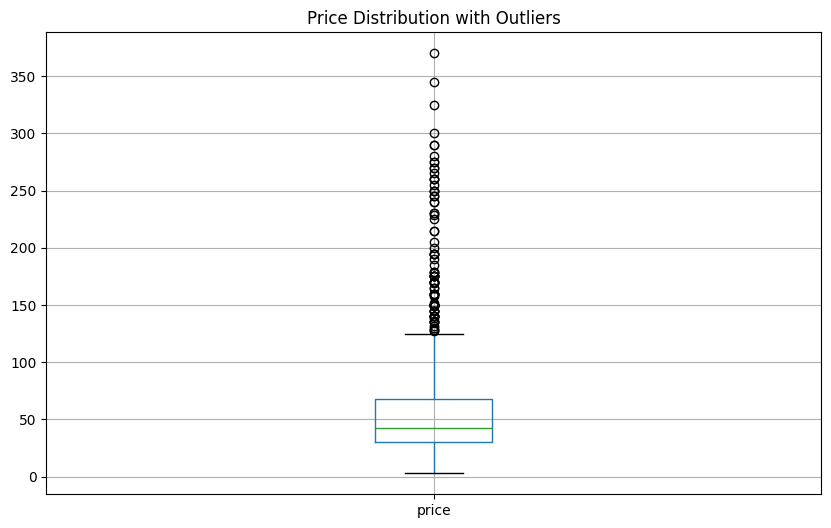

In [22]:
# Visualization to help with decision making
cosmetic.boxplot(column="price")
plt.title("Price Distribution with Outliers")
plt.show()

* Extreme values were flagged for transparency rather than removed indiscriminately.
* Price outliers identified by IQR and vizualizations
* Outliers are included in EDA but are noted where appropriate to preserve real-world variability.

## 5. Exploratory Data Analysis (EDA)
This section provides high-level context on product pricing, rankings, and ingredient usage using the raw cosmetic dataset. These exploratory views help frame later database-driven analyses but are not used directly for conclusions.

In [23]:
# Summary stats: number of ingredients per product
cosmetic['num_ingredients'] = cosmetic['ingredient_list'].apply(len)
cosmetic['num_ingredients'].describe()

count    1472.000000
mean       31.023777
std        22.343225
min         1.000000
25%        17.000000
50%        30.000000
75%        42.000000
max       220.000000
Name: num_ingredients, dtype: float64

In [24]:
# Product types
cosmetic.product_type.value_counts()

product_type
moisturizer    298
cleanser       281
face mask      266
treatment      248
eye cream      209
sun protect    170
Name: count, dtype: int64

In [25]:
cosmetic_exploded = cosmetic.explode('ingredient_list')

# Count how many times each ingredient appears per product_type
ingredient_counts = cosmetic_exploded.groupby(['product_type', 'ingredient_list']).size().reset_index(name='Count')

# For each product_type, find the ingredient with the max count
most_common_ingredient = ingredient_counts.loc[ingredient_counts.groupby('product_type')['Count'].idxmax()].reset_index(drop=True)

print(most_common_ingredient)

  product_type ingredient_list  Count
0     cleanser           water    202
1    eye cream        glycerin    160
2    face mask        glycerin    225
3  moisturizer        glycerin    204
4  sun protect        glycerin     83
5    treatment        glycerin    175


### Ingredient Frequency (Top 25)

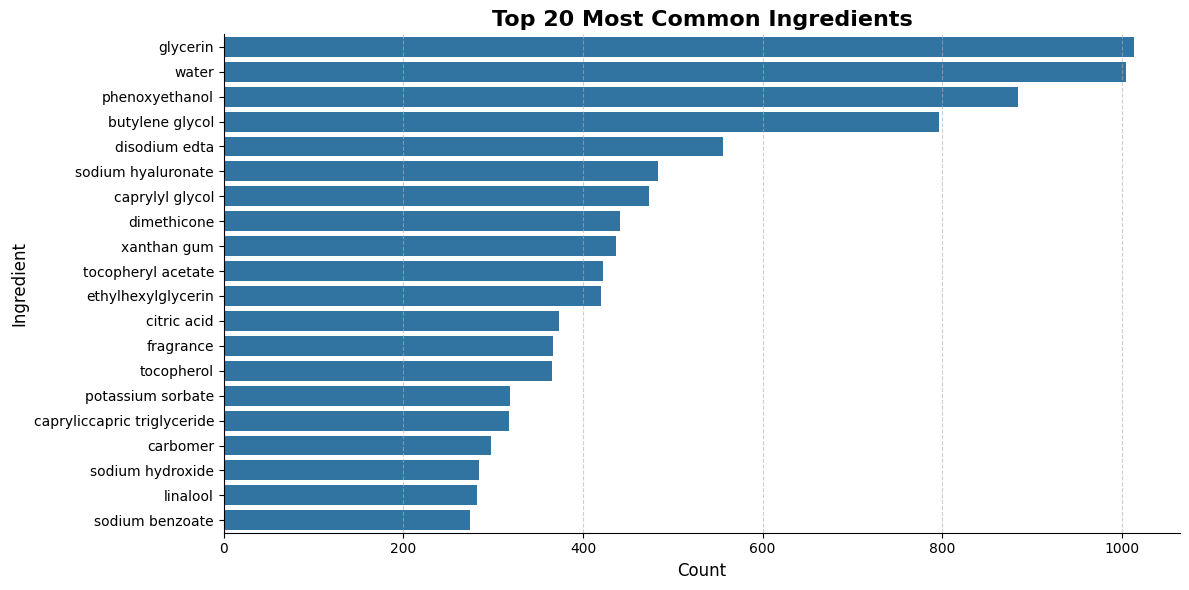

In [26]:
# Get top 20 ingredients by frequency
top_ingredients = (
    cosmetic_exploded['ingredient_list']
    .dropna()                 # Safety: remove NaNs
    .value_counts()           # Count occurrences
    .head(20)                 # Keep only top 20
    .reset_index()
)

top_ingredients.columns = ['ingredient', 'count']

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_ingredients,
    x='count',
    y='ingredient',
    legend=False          # Remove redundant legend
)

# Styling
plt.title('Top 20 Most Common Ingredients', fontsize=16, weight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Ingredient', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine()
plt.tight_layout()
plt.show()

* Top 20 most common ingredients
> Color is used for visual clarity and to emphasize relative frequency, not to encode an additional variable.

### Ingredient Frequency (macro to show drop-off)

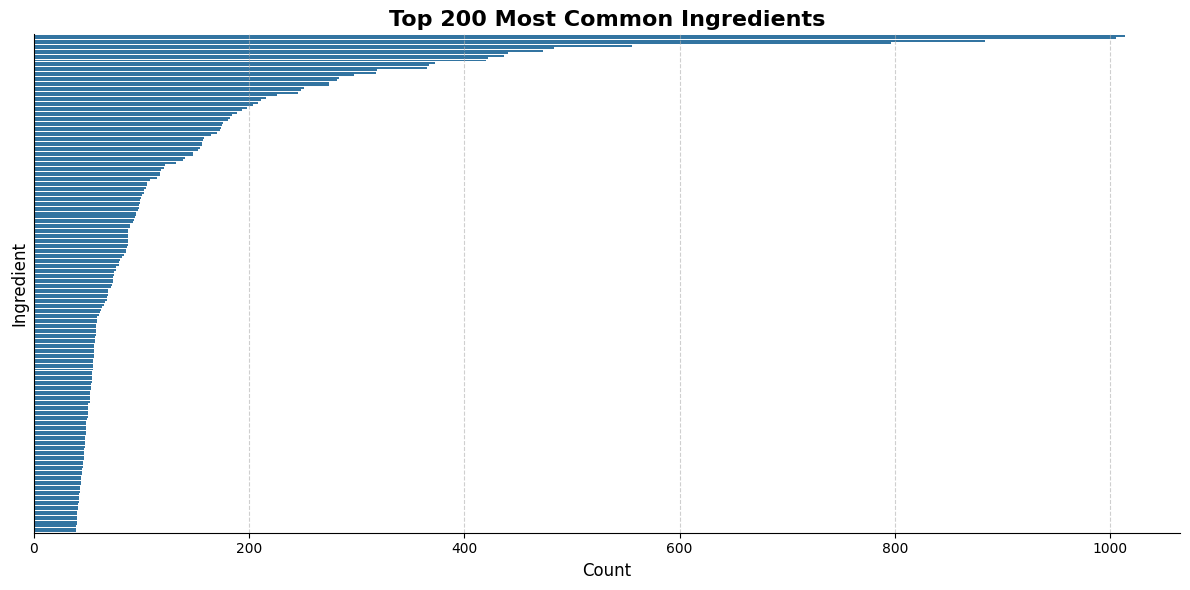

In [27]:
# Get top 200 ingredients by frequency
top_ingredients = (
    cosmetic_exploded['ingredient_list']
    .dropna()
    .value_counts()
    .head(200)
    .reset_index()
)

top_ingredients.columns = ['ingredient', 'count']

# Ensure highest counts appear at the top
top_ingredients = top_ingredients.sort_values('count', ascending=False)

# Plot (same style as Top 20)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_ingredients,
    x='count',
    y='ingredient',
    legend=False
)

plt.title('Top 200 Most Common Ingredients', fontsize=16, weight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Ingredient', fontsize=12)

# Remove ingredient name clutter (optional, recommended for 200)
plt.yticks([])

plt.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine()
plt.tight_layout()
plt.show()

* Long-tail distribution of rarely used ingredients

### Number of ingredients per product

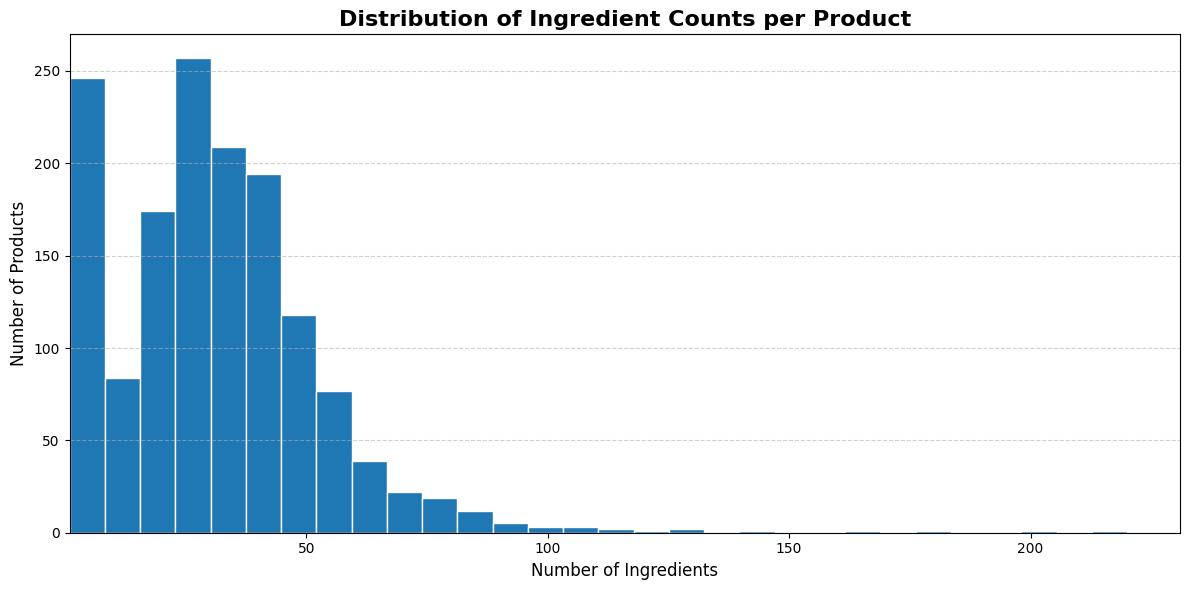

In [28]:
# Ingredient count distribution (start at 1 ingredient)
ingredient_counts = cosmetic['num_ingredients'].dropna()
ingredient_counts = ingredient_counts[ingredient_counts >= 1]

plt.figure(figsize=(12, 6))
plt.hist(
    ingredient_counts,
    bins=30,
    edgecolor='white'
)

plt.title('Distribution of Ingredient Counts per Product', fontsize=16, weight='bold')
plt.xlabel('Number of Ingredients', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xlim(left=1)
plt.tight_layout()
plt.show()

In [29]:
avg_ingredients = cosmetic.loc[
    cosmetic['num_ingredients'] > 0,
    'num_ingredients'
].mean()

print(f"Average number of ingredients per product: {avg_ingredients:.1f}")

Average number of ingredients per product: 31.0


### Ingredient amount by product type:

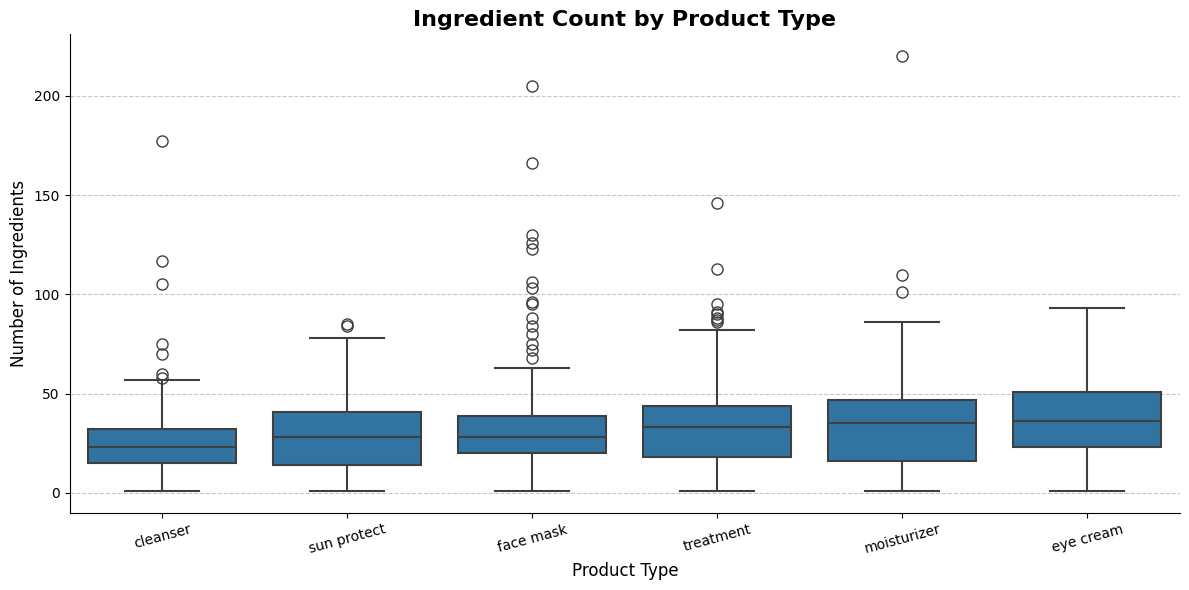

In [30]:
# Sort product types by mean number of ingredients
mean_ingredients = (
    cosmetic.groupby('product_type')['num_ingredients']
            .mean()
            .sort_values()
)

ordered_product_types = mean_ingredients.index

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=cosmetic,
    x='product_type',
    y='num_ingredients',
    order=ordered_product_types,
    legend=False,
    linewidth=1.5,
    fliersize=8
)

plt.title('Ingredient Count by Product Type', fontsize=16, weight='bold')
plt.xlabel('Product Type', fontsize=12)
plt.ylabel('Number of Ingredients', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()
plt.tight_layout()
plt.show()


In [31]:
ingredient_by_type = (
    cosmetic.groupby('product_type')['num_ingredients']
            .agg(['count', 'mean', 'median'])
            .round(1)
            .sort_values('mean')
)

ingredient_by_type

,count,mean,median
product_type,,,
cleanser,281,24.6,23.0
sun protect,170,28.6,28.0
face mask,266,31.3,28.0
treatment,248,32.7,33.0
moisturizer,298,33.6,35.0
eye cream,209,35.5,36.0


* On average, products in this dataset contain between 20 to 40 ingredients, reflecting moderate formulation complexity.

### Product price distribution

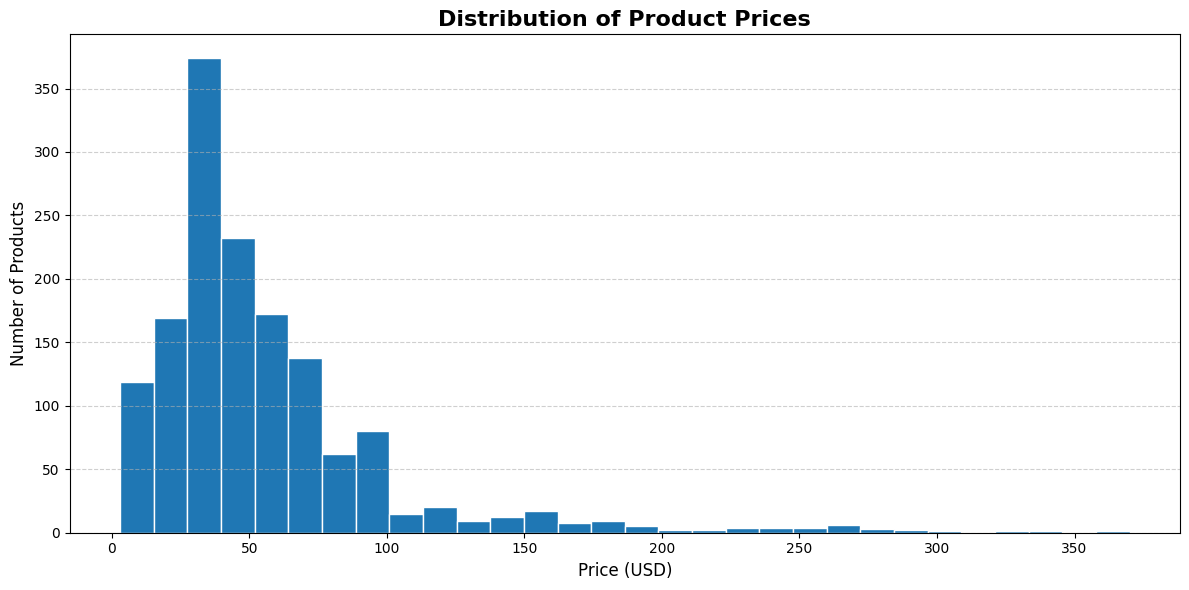

In [32]:
# Price distribution (exclude missing or zero prices)
prices = cosmetic['price'].dropna()
prices = prices[prices > 0]

plt.figure(figsize=(12, 6))
plt.hist(prices, bins=30, edgecolor='white')
plt.title('Distribution of Product Prices', fontsize=16, weight='bold')
plt.xlabel('Price (USD)', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [33]:
avg_price = cosmetic.loc[
    cosmetic['price'] > 0,
    'price'
].mean()

print(f"Average product price: ${avg_price:.2f}")

Average product price: $55.58


In [34]:
most_common_price = cosmetic.loc[
    cosmetic['price'] > 0,
    'price'
].mode().iloc[0]

print(f"Most common product price: ${most_common_price:.2f}")

Most common product price: $38.00


* Skewed distribution show most products clustered in lower price ranges (around $38) 
* Small number of luxury-priced outliers raise the average.

### Price and Rank Analysis

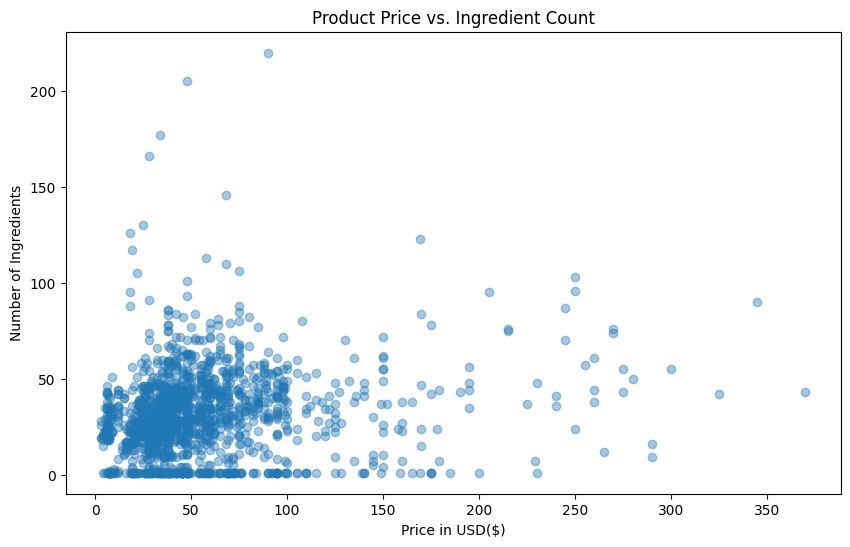

In [35]:
# Create ingredient count column
cosmetic['ingredient_count'] = cosmetic['ingredients'].str.split(',').str.len()

# Price vs. ingredient counts
plt.scatter(cosmetic['price'], cosmetic['ingredient_count'], alpha=0.4)
plt.title('Product Price vs. Ingredient Count')
plt.xlabel('Price in USD($)')
plt.ylabel('Number of Ingredients')
plt.show()

* Product price varies widely across all formulation sizes, suggesting no strong relationship between cost and ingredient count.

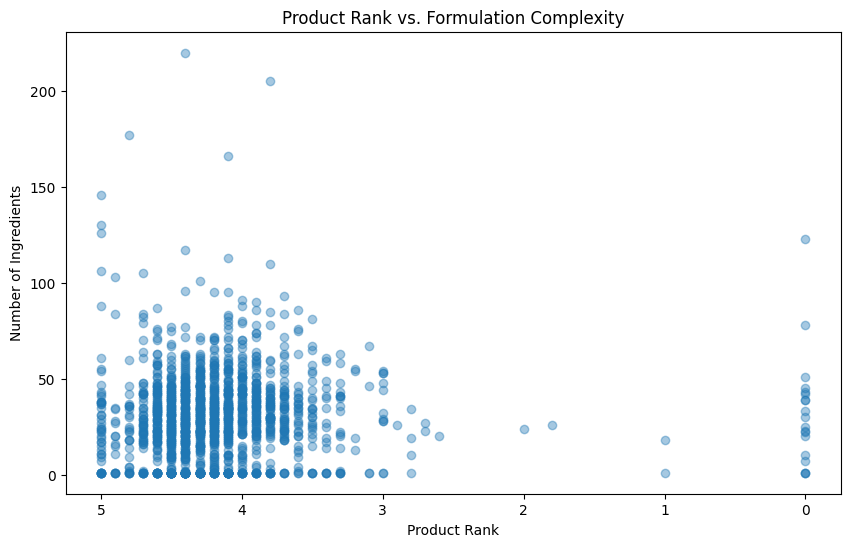

In [36]:
# Rank vs. ingredient count
plt.scatter(cosmetic['rank'], cosmetic['ingredient_count'], alpha=0.4)
plt.title('Product Rank vs. Formulation Complexity')
plt.xlabel('Product Rank')
plt.ylabel('Number of Ingredients')

# Invert x-axis so higher ranks appear first
plt.gca().invert_xaxis()
plt.show()

* Higher-ranked products span a wide range of ingredient counts, showing no clear preference for simpler or more complex formulations.

### Product Price and Ranking

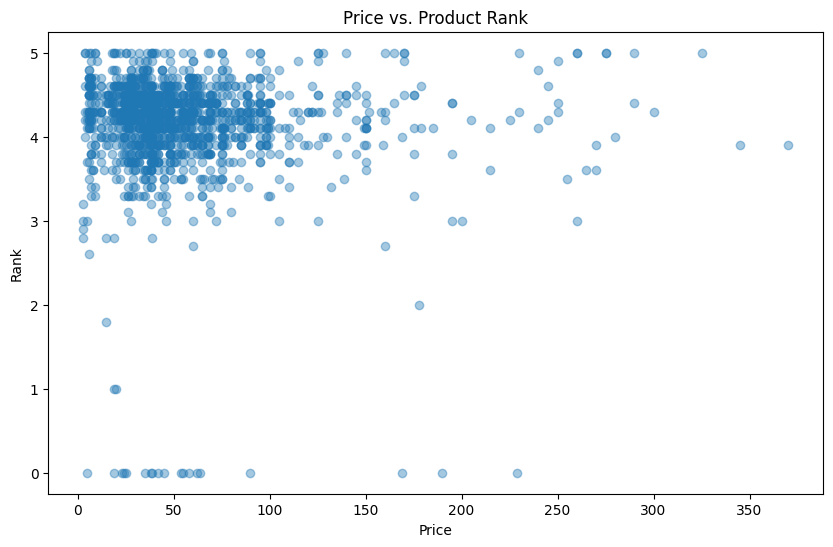

In [37]:
# Price vs. rank

plt.scatter(cosmetic['price'], cosmetic['rank'], alpha=0.4)
plt.title('Price vs. Product Rank')
plt.xlabel('Price')
plt.ylabel('Rank')
plt.show()

* No strong linear relationship between price and ranking suggests that higher-priced products do not consistently receive better rankings.

### Product Formulation Complexity Across Brands

C:\Users\angel\AppData\Local\Temp\ipykernel_43092\3563306127.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


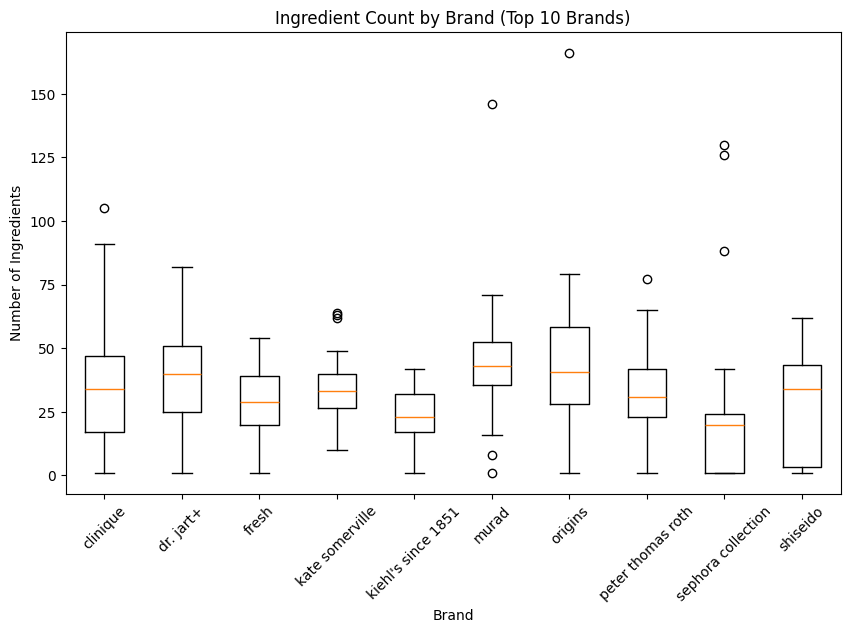

In [38]:
# Filter for top brands
top_brands = cosmetic['brand'].value_counts().head(10).index
brand_data = cosmetic[cosmetic['brand'].isin(top_brands)]

# And plot
plt.boxplot(
    [group['ingredient_count'].dropna()
     for _, group in brand_data.groupby('brand')],
    labels=brand_data.groupby('brand').groups.keys(),
    vert=True
)

plt.title('Ingredient Count by Brand (Top 10 Brands)')
plt.xlabel('Brand')
plt.ylabel('Number of Ingredients')
plt.xticks(rotation=45)
plt.show()

## 6. Database Design & Creation

This project uses SQLite to enforce relational integrity and enable SQL-based analysis.

**Tables**

* Products
* Ingredients
* ProductIngredients (many-to-many)
* IngredientHazards
* ChemicalReports



In [39]:
img = Image.open("schema/beauty_wizard_ERD.png")
plt.imshow(img)
plt.axis("off");

In [40]:
# Database config
DB_PATH = Path("db/BeautyWiz.db")
conn = sqlite3.connect(DB_PATH)

In [41]:
# Enforce foreign keys
conn.execute("PRAGMA foreign_keys = ON;")

# Creates cursor object which ties to db
cursor = conn.cursor()

In [42]:
# Data import
DATA = Path("data")

cosmetic = pd.read_csv(DATA / "cosmetic_p.csv")
beauty = pd.read_csv(DATA / "BeautyFeeds.csv")
cscp = pd.read_csv(DATA / "cscpopendata.csv")

In [43]:
# Validation
print("Cosmetic shape:", cosmetic.shape)
print("BeautyFeeds shape:", beauty.shape)
print("CSCP shape:", cscp.shape)

Cosmetic shape: (1472, 11)
BeautyFeeds shape: (1538, 6)
CSCP shape: (114635, 17)


In [44]:
cosmetic.head()

,Label,brand,name,price,rank,ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1


## 8. Advanced SQL Queries

Examples include:

* Multi-table joins across products, ingredients, and hazards
* Aggregations with HAVING clauses
* Subqueries identifying high-risk ingredients used in top-ranked products



Hazard & Regulatory Signals

### Hazard Coverage

* Percentage of ingredients with hazard data
* Average hazard score per product

### Regulatory Reporting

* Ingredients appearing in CSCP reports
* Report frequency and discontinuation flags

Derived Metric:

* **Product Safety Indicator** = count of flagged ingredients per product

---



In [45]:
# SQL-Derived Metrics: Ingredient Counts
ingredient_counts = pd.read_sql("""
SELECT product_id, COUNT(*) AS ingredient_count
FROM ProductIngredients
GROUP BY product_id
""", conn)

### Query 1: Ingredient complexity by brand

Which brands tend to use more complex formulations (more ingredients per product)?

In [46]:
# Average ingredients per product by brand

conn = sqlite3.connect(DB_PATH)

query_brand_complexity = '''
SELECT
    p.brand,
    COUNT(DISTINCT pi.ingredient_id) * 1.0
        / COUNT(DISTINCT p.product_id) AS avg_ingredients_per_product,
    COUNT(DISTINCT p.product_id) AS product_count
FROM Products p
JOIN ProductIngredients pi
    ON p.product_id = pi.product_id
GROUP BY p.brand
HAVING COUNT(DISTINCT p.product_id) >= 5
ORDER BY avg_ingredients_per_product DESC;
'''

df_brand = pd.read_sql(query_brand_complexity, conn)
df_brand.shape

(116, 3)

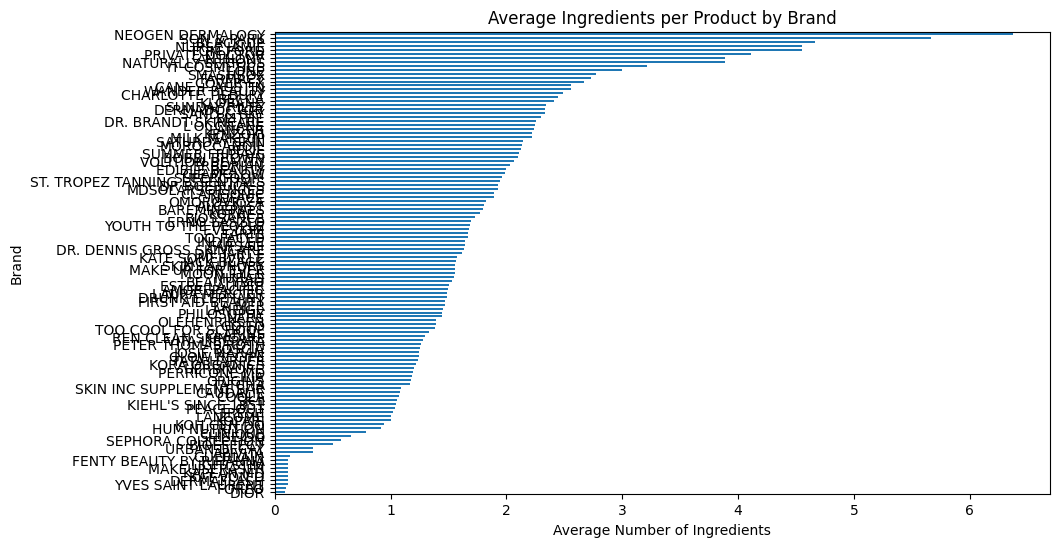

In [52]:
# Q1 Visualization

df_brand.sort_values("avg_ingredients_per_product").plot(
    kind="barh",
    x="brand",
    y="avg_ingredients_per_product",
    legend=False
)
plt.title("Average Ingredients per Product by Brand")
plt.xlabel("Average Number of Ingredients")
plt.ylabel("Brand")
plt.show()

* This analysis compares average formulation complexity across brands by measuring the number of unique ingredients used per product. Brands with higher averages tend to produce more complex formulations.

### Query 2: Most Widely Used Ingredients Across Products

Which ingredients appear most frequently across cosmetic products?

In [48]:
# Ingredient prevalence

conn = sqlite3.connect(DB_PATH)

query_ingredients = '''
SELECT
    i.ingredient_name,
    COUNT(DISTINCT pi.product_id) AS product_count
FROM Ingredients i
JOIN ProductIngredients pi
    ON i.ingredient_id = pi.ingredient_id
GROUP BY i.ingredient_name
HAVING COUNT(DISTINCT pi.product_id) >= 20
ORDER BY product_count DESC
LIMIT 25;
'''

df_top_ingredients = pd.read_sql(query_ingredients, conn)
df_top_ingredients.shape

(25, 2)

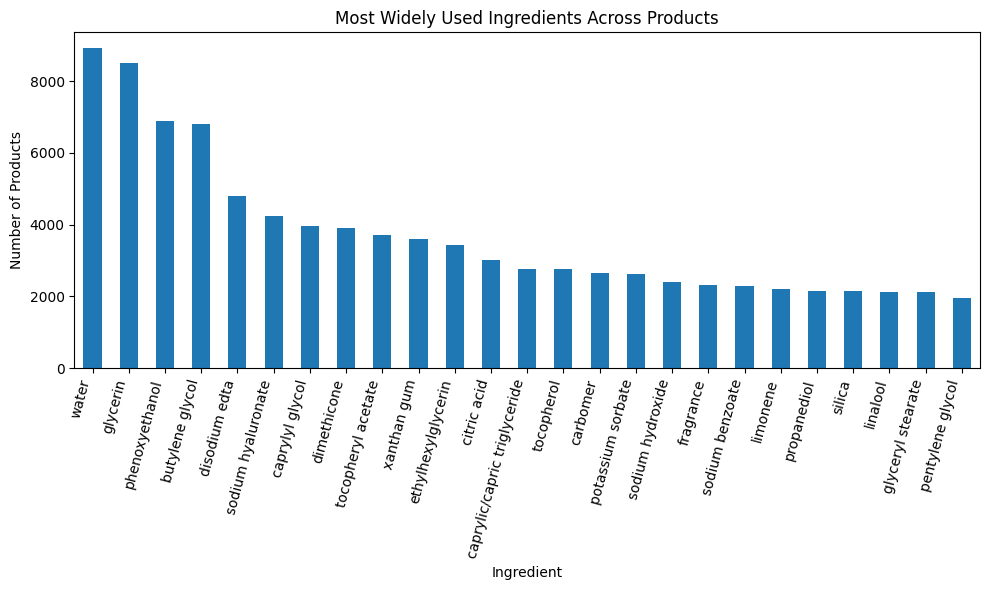

In [49]:
# Q2 Visualization

df_top_ingredients.plot(
    kind="bar",
    x="ingredient_name",
    y="product_count",
    legend=False
)
plt.title("Most Widely Used Ingredients Across Products")
plt.xlabel("Ingredient")
plt.ylabel("Number of Products")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

This query identifies ingredients that appear most frequently across cosmetic products, highlighting formulation staples that dominate product compositions.

### Query 3: Products with regulatory history

This query connects consumer products to chemical regulatory records, surfacing products that contain ingredients with documented reporting or discontinuation histories.

The resulting table provides ingredient-level transparency, while brand-level aggregation supports broader analysis of regulatory exposure across product lines.

**Visualization: Table + supporting bar chart, Primary: Clean, formatted table (brand, product, ingredient, report count), Secondary Bar chart: Count of regulated ingredients per brand, Why: Regulatory data is detail-oriented and best shown first in tabular form, Aggregated chart supports brand-level comparison*

In [50]:
# Products containing ingredients with chemical reporting records

conn = sqlite3.connect(DB_PATH)

query = """
WITH regulated_ingredients AS (
    SELECT
        ingredient_id,
        MAX(report_count) AS report_count,
        MAX(first_reported) AS first_reported,
        MAX(most_recent_report) AS most_recent_report,
        MAX(discontinued_date) AS discontinued_date
    FROM ChemicalReports
    WHERE report_count > 0
    GROUP BY ingredient_id
)
SELECT
    p.brand,
    p.product_name AS product,
    i.ingredient_name AS ingredient,
    r.first_reported,
    r.most_recent_report,
    r.discontinued_date,
    r.report_count
FROM regulated_ingredients r
JOIN Ingredients i
    ON r.ingredient_id = i.ingredient_id
JOIN ProductIngredients pi
    ON i.ingredient_id = pi.ingredient_id
JOIN Products p
    ON pi.product_id = p.product_id
ORDER BY r.report_count DESC
LIMIT 500;
"""

df_regulated_products = pd.read_sql(query, conn)
df_regulated_products.head()

,brand,product,ingredient,first_reported,most_recent_report,discontinued_date,report_count
0,TATCHA,The Water Cream,titanium dioxide,None,12/31/2019,12/31/2019,8
1,SUNDAY RILEY,Tidal Brightening Enzyme Water Cream,titanium dioxide,None,12/31/2019,12/31/2019,8
2,AMOREPACIFIC,Color Control Cushion Compact Broad Spectrum S...,titanium dioxide,None,12/31/2019,12/31/2019,8
3,DR. JART+,Cicapair ™ Tiger Grass Color Correcting Treatm...,titanium dioxide,None,12/31/2019,12/31/2019,8
4,IT COSMETICS,Your Skin But Better™ CC+Illumination™ Cream w...,titanium dioxide,None,12/31/2019,12/31/2019,8


In [51]:
conn = sqlite3.connect(DB_PATH)

query = '''
WITH regulated_ingredients AS (
    SELECT
        ingredient_id,
        SUM(report_count) AS total_reports
    FROM ChemicalReports
    WHERE report_count > 0
    GROUP BY ingredient_id
)
SELECT
    p.brand,
    COUNT(DISTINCT r.ingredient_id) AS regulated_ingredient_count,
    SUM(r.total_reports) AS total_reports
FROM regulated_ingredients r
JOIN ProductIngredients pi
    ON r.ingredient_id = pi.ingredient_id
JOIN Products p
    ON pi.product_id = p.product_id
GROUP BY p.brand
ORDER BY total_reports DESC;
'''

df_regulated_products = pd.read_sql(query, conn)
df_regulated_products.head()

,brand,regulated_ingredient_count,total_reports
0,DR. JART+,5,17728416
1,SHISEIDO,7,11550114
2,PETER THOMAS ROTH,7,7674840
3,ALGENIST,7,6402294
4,AMOREPACIFIC,5,6046866


## 10. Key Findings

* A small subset of ingredients dominates cosmetic formulations
* Most products contain a long tail of low-frequency ingredients
* Regulatory and hazard reporting is concentrated among relatively few chemicals
* Ingredient diversity does not strongly correlate with price

---



## 11. Limitations

* Ingredient presence does not imply concentration or exposure level
* Hazard scores are source-dependent and not definitive safety measures
* Dataset coverage varies by brand and product category

---



## 12. Conclusion & Next Steps

This project demonstrates an end-to-end data analysis workflow including ETL, database design, SQL analysis, Python EDA, and professional documentation. Future extensions could include:

* Automated data refresh
* API-driven product lookups
* Integration of consumer review sentiment

---



## 13. Reproducibility Notes

* All work performed via command line Git commits
* No file uploader used after initial dataset acquisition
* Notebook structured for portfolio and PDF export (if needed)
